## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [21]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as st
%matplotlib inline
#We are setting the seed to assure to get the same answers everytime.
random.seed(42)

a. Read in the dataset.

In [22]:
df = pd.read_csv('/kaggle/input/ab-testing-e-commerce-website/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. find the number of rows in the dataset.

In [23]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [24]:
len(df['user_id'].unique())

290584

d. The proportion of users converted.

In [25]:
len(df[df['converted'] == 1])/len(df) 

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [26]:
len(df[ (df['group'] != 'treatment')  &  (df['landing_page'] == 'new_page')  ]) + len(df[ (df['group'] == 'treatment')  &  (df['landing_page'] != 'new_page')  ])
#OR
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

# **Data Cleaning**

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


ANS: NO

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

In [28]:
# Removing the inaccurate rows, and store the result in a new dataframe df2
nodf = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].user_id
nodf = nodf.index.tolist()
df2 = df.drop(nodf)
df2.head(20)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [29]:
# Double Check all of the correct rows were removed - this should be 0
print(df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0])

0


`3.` Working on new dataset df2.

a. How many unique **user_id**s are in **df2**?

In [30]:
len(df2['user_id'].unique())

290584

In [31]:
df2['index'] = df2.index
df2.head()

,user_id,timestamp,group,landing_page,converted,index
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,3
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,4


b. Is there is **user_id** repeated in **df2** (duplicated rows), if so What is it?

In [32]:
re = df2['user_id'].duplicated()
re = pd.Series.to_frame(re)
re = re[re['user_id'] == True]
re = re.index[0]
re

2893

There is on **user_id** repeated and is **2893**

c. What is the row information for the repeat **user_id**? 

In [33]:
df2[df2['index'] == re]

,user_id,timestamp,group,landing_page,converted,index
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,2893


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [34]:
df2.shape[0]

290585

In [35]:
# Remove one of the rows with a duplicate user_id.

df2 = df2.drop_duplicates('user_id')
df2.shape[0]

290584

`4.` Using **df2**.

a. What is the probability of an individual converting regardless of the page they receive?

In [36]:
len(df2[df2['converted'] == 1])/len(df2)

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [37]:
inter = len(df2[  (df2['converted'] == 1)   &   (df2['group'] == 'control' )])/len(df2)
prob_ctrl = len(df2[df2['group'] == 'control'])/len(df2)
b = inter/prob_ctrl
b

0.12038630450046119

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [38]:
inter = len(df2[  (df2['converted'] == 1)   &   (df2['group'] == 'treatment' )])/len(df2)
prob_tr = len(df2[df2['group'] == 'treatment'])/len(df2)
c = inter/prob_tr
c

0.11880806551510564

In [39]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = b - c
obs_diff

0.0015782389853555429

d. What is the probability that an individual received the new page?

In [40]:
len(df2[df2['landing_page'] == 'new_page'])/len(df2)

0.5000619442226688

e. Until now, is there is sufficient evidence to say that the new treatment page leads to more conversions.

it depends on the **acceptance error** (alpha of A/B test). However, from probilistic overview we can see that this new page does not leads to more conversion, **50%** of the dataset receive the new page **11.9%** only pay for a page, this indicates that the new page does not increase the revenue of the company.

<a id='ab_test'></a>
### Part II - A/B Test
`1.`
Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


Ho: $p_{new}$ <= $p_{old}$  **old page is better**


Ha: $p_{new}$  > $p_{old}$  **new page is better**

`2.`

a. What is the **convert rate** for $p_{new}$ under the null? 

In [41]:
p_new = len(df2[ (df2['converted'] == 1)])/len(df2)

p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [42]:
p_old = len(df2[ (df2['converted'] == 1)])/len(df2)

p_old

0.11959708724499628

c. What is $n_{new}$?

In [43]:
len(df2[df2['landing_page'] == 'new_page'])

145310

d. What is $n_{old}$?

In [44]:
len(df2[df2['landing_page'] == 'old_page'])

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [45]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1], size = 145310)
p_new_s = len(new_page_converted[new_page_converted == 1])/145310
p_new_s

0.5002821553919207

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [46]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1], size = 145274)
p_old_s = len(old_page_converted[old_page_converted == 1])/145274
p_old_s

0.500433663284552

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [47]:
p_new_s - p_old_s
#approximatly = 0

-0.00015150789263129738

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values.

In [48]:
# Sampling distribution 
p_diffs = []
sim_new = np.random.binomial(145310, p_new, 10000)/145310
sim_old = np.random.binomial(145274, p_old, 10000)/145274
p_diffs = sim_new - sim_old

In [49]:
obs_diff = df2[df2['group'] == 'treatment']['converted'].mean() -  df2[df2['group'] == 'control']['converted'].mean()
obs_diff

-0.0015782389853555567

i. Plot a histogram of the **p_diffs**.

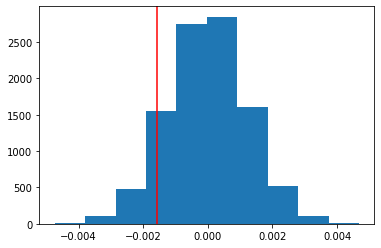

In [50]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)
plt.axvline(x = obs_diff
, c = 'red')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [51]:
p_value = (p_diffs > obs_diff).mean()
p_value

0.9001

**Value computed in part j called p value and it used to conclude the hypothesis tests, if 'p <= alpha' we have a signficent evidence to reject Ho, while if 'p > alpha' we will not reject Ho as in this example as p = 0.9058 and alpha = 0.05. So, thier is no need for a new page as the old page sale almost the same amount.**

A/B test using built-in statsmodels to achieve same results.

In [52]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = len(df2[ (df2['converted'] == 1)  &  (df2['landing_page'] == 'old_page')])

# number of conversions with the new_page
convert_new = len(df2[ (df2['converted'] == 1)  &  (df2['landing_page'] == 'new_page')])

# number of individuals who were shown the old_page
n_old = len(df2[df2['landing_page'] == 'old_page'])

# number of individuals who received new_page
n_new = len(df2[df2['landing_page'] == 'new_page'])
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

In [55]:
from statsmodels.stats.proportion import proportions_ztest
count = np.array([convert_new, convert_old])
nobs = np.array([n_new, n_old])
z_score, p_value = proportions_ztest(count, nobs, alternative = 'larger')
z_score, p_value
Z_score_95 = st.norm.ppf(.95)
alpha = 0.05
print(Z_score_95, z_score)
print(alpha, p_value)

1.6448536269514722 -1.3109241984234394
0.05 0.9050583127590245


We can conclude using two ways either by: **1) z_score < z_score_95.** OR **2) p_value > alpha.** Both Z-test and bootstrapping method conclude to the same result at the same level of signficent which is we can not reject Ho as conversion rate for old page will be larger or equal to conversion rate of new page so no need for this new page.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

logistic regression will be used, as our response variable is binary categorical.

In [56]:
df2['intercept'] = 1
df2[['ab_page', 'no_ab_page']] = pd.get_dummies(df['landing_page'])

df2 = df2.drop('no_ab_page',axis =1)
df2.head()

,user_id,timestamp,group,landing_page,converted,index,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,3,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,4,1,0


In [57]:
log_m = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
r = log_m.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [58]:
r.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2023-01-15 16:17 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

Ho: $p_{new}$ - $p_{old}$ = 0 

H1: $p_{new}$ - $p_{old}$ != 0 


The p value (0.1899) is also > alpha(=0.05), it's a different value from part II as the hypothesis test in the regression is two sided test whether in part II was one sided. And as p value > alpha then conversion is not signficantly dependent on the ab_page variable. So, the new page isn't nessecary at all as in partI and partII.

The problem her is that the new page doesn't affect the revenue or conversion rate as the conversion rate for old page is approximatly the same as new page. Adding any explonatory variables her is pointless as we can see next. As there is a problrm for multi-independent variables as they must be uncorrelated from each other and correlated with response so you must keep that on mind if you intend to increase independent variable this problem called multicollinearity by the way.

If the country of each user affect the conversion?

In [60]:
# Read the countries.csv
df3 = pd.read_csv('/kaggle/input/ab-testing-e-commerce-website/countries.csv')
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [61]:
# Join with the df2 dataframe
df_merged = pd.DataFrame()
df_merged = df2.merge(df3, on ='user_id')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,index,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,3,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,4,1,0,US


In [62]:
# Create the necessary dummy variables
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])
df_merged = df_merged.drop('CA', axis = 1)
df_merged.head()

,user_id,timestamp,group,landing_page,converted,index,intercept,ab_page,country,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,0,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2,1,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,3,1,1,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,4,1,0,US,0,1


In [63]:
## g) 2
# Fit your model, and summarize the results.
df_merged['intercept'] = 1
log_m = sm.Logit(df_merged['converted'], df_merged[['intercept', 'UK', 'US']])
res = log_m.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2023-01-15 16:23 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

At 0.05 level of signficant we can say that country variable does not affect conversion rate.

now we looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [64]:
# Fit your model, and summarize the results
df_merged['ab_UK'] = df_merged['ab_page'] * df_merged['UK']
df_merged['ab_US'] = df_merged['ab_page'] * df_merged['US']
df_merged['intercept'] = 1
log_m = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US', 'ab_UK', 'ab_US']])
res = log_m.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2023-01-15 16:25 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
ab_UK          0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
ab_US          0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

It's clear that at 0.05 level of signfigence the intersection factor between the page and country does not affect the conversion of the user.